# BCN 2020-2021 Ensemble (with Important Features)

**Ensemble methos used: XGBoost**

XGBoost is built on the principles of ensemble modeling and is an improved version of the Gradient Boosted Machine algorithm. In general, the XgBoost algorithm creates multiple classifiers that are weak learners, which means a model that gives a bit better accuracy than just a random guess.

_This model is only runned with the most important features that Gridsearch have gave us on our previous step (Train our model with all variables)._

**Index**

1. [Environment](#Environment)
2. [Feature Preprocessing ](#FeaturePreprocessing )
3. [Model](#Model)
    - Gridsearch
    - Random Forest Classifier (with best params)
    - Feature Importance


4. [Conclusions](#Conclusions)

## Environment

#### Import libraries

In [1]:
# Pandas and Numpy
import pandas as pd
import numpy as np

# Maths
import math
from scipy import stats

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

try:
    from xgboost import XGBClassifier
except:
    from sklearn.ensemble import GradientBoostingClassifier as XGBClassifier

#### Import data

In [2]:
all_apps = pd.read_csv("apps_BCN20201_clean_Sel_addCols.csv")

In [3]:
all_apps.shape

(116, 22)

In [4]:
apps=all_apps[["Time Conversion - days","Time First touchpoint to Close date - days", "Discount(%)",
               "Time between Created Date and Start Date - days","Stage Duration","Creater Quarter",
               "Hours Before First Touchpoint","Creater Month","Discount","Time to first touchpoint - days",
               "Paid Deposit"]]

In [5]:
apps.head()

,Time Conversion - days,Time First touchpoint to Close date - days,Discount(%),Time between Created Date and Start Date - days,Stage Duration,Creater Quarter,Hours Before First Touchpoint,Creater Month,Discount,Time to first touchpoint - days,Paid Deposit
0,76,34,0.10,74,77.0,3,1010.94,7,1,42,0
1,58,5,0.00,148,229.0,1,1275.60,2,0,53,0
2,42,36,0.07,74,102.0,3,149.47,7,1,6,1
3,70,70,0.00,206,218.0,1,1.69,3,0,0,1
4,5,1,0.10,116,99.0,2,88.11,6,1,4,0


In [6]:
apps.shape

(116, 11)

In [7]:
apps.dtypes

Time Conversion - days                               int64
Time First touchpoint to Close date - days           int64
Discount(%)                                        float64
Time between Created Date and Start Date - days      int64
Stage Duration                                     float64
Creater Quarter                                      int64
Hours Before First Touchpoint                      float64
Creater Month                                        int64
Discount                                             int64
Time to first touchpoint - days                      int64
Paid Deposit                                         int64
dtype: object

## Feature Preprocessing 
It turns raw data into a one that is usable by a machine learning model.

_For this classification it won't be needed as all column types are numeric._

In [8]:
features_to_encode = apps.columns[apps.dtypes==object].tolist()

In [9]:
col_transformer_e = make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), features_to_encode),
    remainder="passthrough")

## Model

In [10]:
X = apps.drop(['Paid Deposit'],axis=1)
y = apps['Paid Deposit']

In [11]:
y.value_counts()

0    84
1    32
Name: Paid Deposit, dtype: int64

### Gridsearch

In [12]:
from imblearn.pipeline import Pipeline as imbPipeline

In [13]:
def gridsearch(X,y):
    
    # Create Params
    param_grid = {
        'XGBClassifier__learning_rate': [0.1, 0.3],
        'XGBClassifier__max_depth': [3, 5, 7],
        'XGBClassifier__n_estimators': [30, 50, 100, 150]
    }

    
    # Create a based model
    xgb = XGBClassifier()

    #pipe = make_pipeline(col_transformer_e, rf_classifier)

    #pipe = make_pipeline(TomekLinks(sampling_strategy='majority'), xgb)
    pipe = imbPipeline([
            ('sampling',TomekLinks(sampling_strategy='majority')),
            ('XGBClassifier', xgb)
        ])
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
    
    # X,y or X_train,y_train - might change depending on the circumstances of the model
    grid_search.fit(X, y)
    
    return grid_search.best_estimator_

In [14]:
best_model= gridsearch(X,y)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.1s


[19:58:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   42.9s finished
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [15]:
best_model

Pipeline(steps=[('sampling', TomekLinks(sampling_strategy='majority')),
                ('XGBClassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=30,
                               n_jobs=4, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

### Random Forest Classifier
Using its best params that we got from Gridsearch

In [16]:
def xgb_report(X, y, model, target_names = ['Not Paid Deposit', 'Paid Deposit']):
    
    results = []
    
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    

    cv = cross_val_score(model, X, y, cv=StratifiedKFold(), scoring = "accuracy")
    
    clf = model.fit(X, y)
    y_pred=clf.predict(X)
        
    print("Classification Report")
    print(classification_report(y, y_pred, target_names=target_names))
    print("Confusion_matrix \n",confusion_matrix(y, y_pred),"\n")
        
    results.append(cv)
    
    final_df = pd.DataFrame(cv)
    final_df.rename(columns={0:'Cross Validaton Score'},inplace=True)
    
    print(final_df)

In [17]:
X = apps.drop(['Paid Deposit'],axis=1)
y = apps['Paid Deposit']
xgb_report(X, y, best_model)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder i

[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:58:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification Report
                  precision    recall  f1-score   support

Not Paid Deposit       0.93      0.98      0.95        84
    Paid Deposit       0.93      0.81      0.87        32

        accuracy                           0.93       116
       macro avg       0.93      0.89      0.91       116
    weighted avg       0.93      0.93      0.93       116

Confusion_matrix 
 [[82  2]
 [ 6 26]] 

   Cross Validaton Scor

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


**Interpretation**

- **The Classification Report:**
    - **Accuracy** tells you what percentage of the predictions are correct.
    - **Precision** tells us the following: from the positive predictions I have made, what percentage are positive.
    - **Recall** (opposed to precision), is useful when the cost of a false negative is high. It tells us: of all the positive predictions, what percentage confirms the predicition.
    - **F1-score** seeks a balance between precision and recall.


- **Confusion_matrix**
    - T0 (True Not Paid Deposit): 82 
    - F0 (False Not Paid Deposit): 2
    - T1 (True Paid Deposit): 26
    - F1 (False Paid Deposit): 6


- **Cross Validaton Score**

    It is the technique for assessing how the statistical analysis generalises to an independent data set.It is a technique for evaluating machine learning models by training several models on subsets of the available input data and evaluating them on the complementary subset of the data.

### FeatureImportance

In [20]:
def xgb_feature_importance(model):
    
    xgb=best_model.steps[1][1]
    
    ct=X
    ct_cols=ct.columns
    
    importances = pd.DataFrame({'feature':ct_cols,'importance':np.round(xgb.feature_importances_,3)})
    importances = importances.sort_values('importance',ascending=False).set_index('feature')
    
    top20=importances[:10]

    top20.plot.barh()
    plt.title('Top10 RF Feature Importance')

    plt.show()

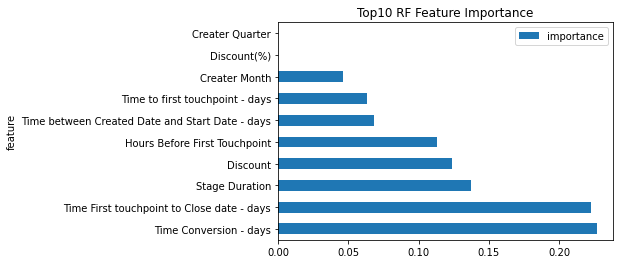

In [21]:
xgb_feature_importance(best_model)

## Conclusion

After modeling with only the selected features from our previous random forest results, we find that the model give us better results.